<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/7RO/TAREA%209%20DQN%20MOUNTAIN%20CAR%20CONTINUOUS/DQN_MOUNTAIN_CAR_CONTINUOUS_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento DDQN en MountainCarContinuous-v0

Este cuaderno implementa un agente de **Aprendizaje por Refuerzo** utilizando el algoritmo **Double Deep Q-Network (DDQN)** sobre el entorno `MountainCarContinuous-v0` de OpenAI Gym.

## Introducción y contexto

El **aprendizaje por refuerzo** consiste en que un agente interactúa con un entorno y aprende a tomar decisiones para maximizar una recompensa acumulada a lo largo del tiempo. En el entorno *MountainCarContinuous-v0*, el agente controla un coche que debe alcanzar la cima de una montaña, situación en la que la acción es continua.

Para aplicar DDQN en este entorno se procede a **discretizar** el espacio de acción continuo en 8 valores equiespaciados en el rango `[-1.0, 1.0]`. Esto permite adaptar la solución basada en Q-Learning a un problema originalmente continuo.

El **DDQN** mejora la estabilidad del aprendizaje al utilizar dos redes neuronales: una para la selección de acciones y otra (target) para evaluar los valores futuros, reduciendo así el sesgo en la estimación de los Q-valores.

A lo largo del cuaderno se incluye:
- Configuración del entorno y discretización de acciones.
- Construcción del modelo DDQN (con dos capas ocultas de 64 neuronas cada una y función de activación ReLU).
- Definición de hiperparámetros y buffer de experiencia.
- Políticas (epsilon-greedy) y función de recompensa personalizada.
- Registro de estadísticas en CSV y TensorBoard.
- Evaluaciones periódicas y final.
- Grabación de video y generación de GIF.
- Análisis visual y consideraciones sobre la reproducibilidad.


# Configuración inicial del entorno de trabajo

Esta celda realiza la configuración inicial necesaria para el entrenamiento del agente DDQN en el entorno MountainCarContinuous-v0:

1. **Importación de bibliotecas**:
   - **Gym**: Framework para entornos de aprendizaje por refuerzo
   - **NumPy y Pandas**: Manipulación de datos y operaciones numéricas
   - **TensorFlow/Keras**: Construcción y entrenamiento de redes neuronales
   - **Matplotlib**: Visualización de resultados
   - **Deque**: Estructura de datos eficiente para el buffer de experiencia
   - **CV2 e Imageio**: Procesamiento y guardado de imágenes/videos
   - **Logging**: Control de mensajes de registro

2. **Compatibilidad de tipos de datos**:
   - Asegura la compatibilidad con `np.bool8` para evitar advertencias de deprecación

3. **Estructura de directorios**:
   - Crea automáticamente los directorios necesarios para:
     - `checkpoints`: Almacenamiento de modelos entrenados
     - `statistics`: Registro de métricas de entrenamiento
     - `logs`: Archivos de registro para TensorBoard
     - `videos`: Grabaciones del agente en acción

Esta configuración establece el entorno de trabajo completo, garantizando que todas las dependencias estén disponibles y que la estructura de archivos esté preparada para el entrenamiento, evaluación y análisis del agente.


In [ ]:
# Importación de librerías y configuración inicial
import gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import datetime
import pickle
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import cv2
import imageio
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Asegurar compatibilidad con np.bool8
np.bool = np.bool8

# Crear directorios necesarios: checkpoints, statistics, logs, videos
directories = ['checkpoints', 'statistics', 'logs', 'videos']
for dir_name in directories:
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        print(f"Directorio '{dir_name}' creado.")


C:\Users\admin\AppData\Local\Temp\ipykernel_5996\242680628.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool = np.bool8


# Configuración del entorno y discretización del espacio de acción

Esta celda implementa dos componentes fundamentales para adaptar el algoritmo DDQN al entorno MountainCarContinuous-v0:

## 1. Inicialización del entorno

Se crea una instancia del entorno MountainCarContinuous-v0 utilizando OpenAI Gym y se extrae la dimensionalidad del espacio de estados:

- **Entorno**: MountainCarContinuous-v0
- **Dimensión del estado**: 2 (posición y velocidad del automóvil)

## 2. Discretización del espacio de acción

Un aspecto crucial de esta implementación es la **discretización del espacio de acción continuo**:

- El entorno original acepta acciones continuas en el rango [-1.0, 1.0]
- Se discretiza este espacio en 8 valores equiespaciados
- Esta transformación permite aplicar el algoritmo DDQN (diseñado para espacios discretos) a un problema con espacio de acción continuo

La discretización es una técnica de aproximación que:
- Simplifica el problema de aprendizaje
- Reduce el espacio de búsqueda
- Permite utilizar algoritmos eficientes basados en Q-learning

Los valores discretos resultantes (como se muestra en la salida) proporcionan suficiente granularidad para que el agente pueda aprender una política efectiva mientras mantiene la complejidad computacional bajo control.


In [ ]:
# Configuración del entorno y discretización de acciones

env = gym.make('MountainCarContinuous-v0')
state_size = env.observation_space.shape[0]
print("Tamaño del estado:", state_size)

# Discretización del espacio de acción en 8 acciones equiespaciadas en [-1.0, 1.0]
n_discrete_actions = 8
discrete_actions = np.linspace(env.action_space.low[0], env.action_space.high[0], n_discrete_actions)
print("Acciones discretas:", discrete_actions)


Tamaño del estado: 2
Acciones discretas: [-1.         -0.71428571 -0.42857143 -0.14285714  0.14285714  0.42857143
  0.71428571  1.        ]


# Arquitectura de la red neuronal para DDQN

Esta celda implementa la arquitectura de la red neuronal utilizada en el algoritmo Double Deep Q-Network (DDQN), un componente crítico para el éxito del agente:

## 1. Función de construcción del modelo

La función `build_model()` crea una red neuronal con la siguiente arquitectura:

- **Capa de entrada**: Dimensión igual al tamaño del estado (2 para MountainCarContinuous-v0)
- **Primera capa oculta**: 64 neuronas con activación ReLU
- **Segunda capa oculta**: 64 neuronas con activación ReLU
- **Capa de salida**: 8 neuronas (una por cada acción discretizada) con activación lineal

### Características del modelo:
- **Función de pérdida**: Error Cuadrático Medio (MSE)
- **Optimizador**: Adam con tasa de aprendizaje de 0.001
- **Parámetros totales**: 4,872 (aproximadamente 19 KB)

## 2. Implementación del enfoque DDQN

El algoritmo DDQN utiliza dos redes neuronales idénticas:

1. **Modelo principal (`model`)**: Utilizado para seleccionar acciones y actualizar pesos
2. **Modelo objetivo (`target_model`)**: Utilizado para estimar los valores Q futuros

Inicialmente, ambos modelos se crean con la misma arquitectura y se sincronizan sus pesos. Durante el entrenamiento:
- El modelo principal se actualiza constantemente
- El modelo objetivo se actualiza periódicamente copiando los pesos del modelo principal

Esta separación es fundamental para el algoritmo DDQN, ya que:
- Reduce el sesgo de sobreestimación presente en DQN tradicional
- Estabiliza el proceso de aprendizaje
- Mejora la convergencia hacia políticas óptimas

La arquitectura seleccionada proporciona un equilibrio entre capacidad expresiva (suficiente para capturar la dinámica del problema) y eficiencia computacional (entrenamiento rápido con recursos limitados).


In [ ]:
# Construcción del modelo DDQN
# Arquitectura:
# - Entrada: tamaño igual al del estado.
# - Dos capas ocultas de 64 neuronas con activación ReLU.
# - Salida: n_discrete_actions (activación lineal).

def build_model(state_size, n_discrete_actions):
    model = Sequential()
    model.add(Input(shape=(state_size,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_discrete_actions, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

# Crear el modelo principal y el target model, y sincronizarlos
model = build_model(state_size, n_discrete_actions)
target_model = build_model(state_size, n_discrete_actions)
target_model.set_weights(model.get_weights())

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 4872 (19.03 KB)
Trainable params: 4872 (19.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Configuración de hiperparámetros estructuras de memoria

Esta celda define los hiperparámetros críticos y las estructuras de memoria necesarias para el algoritmo DDQN:

## 1. Hiperparámetros de aprendizaje

- **Factor de descuento (gamma = 0.99)**: Determina la importancia de las recompensas futuras. Un valor cercano a 1 indica que el agente valora casi igual las recompensas futuras que las inmediatas.

- **Parámetros de exploración epsilon-greedy**:
  - **Epsilon inicial (1.0)**: Garantiza exploración completa al inicio del entrenamiento
  - **Epsilon mínimo (0.01)**: Mantiene un nivel mínimo de exploración incluso al final
  - **Tasa de decaimiento (0.995)**: Controla la velocidad de transición de exploración a explotación

- **Tamaño de batch (64)**: Número de muestras utilizadas en cada actualización del modelo

- **Número de episodios (300)**: Total de episodios de entrenamiento

- **Frecuencia de actualización del target model (10)**: Cada cuántos episodios se sincronizan los pesos del modelo principal al modelo objetivo

- **Intervalo de guardado de checkpoints (50)**: Frecuencia para guardar el estado del modelo

## 2. Buffer de experiencia

- **Replay Buffer**: Estructura de datos `deque` con capacidad máxima de 2000 transiciones
  - Almacena experiencias (estado, acción, recompensa, siguiente estado, terminado)
  - Permite muestreo aleatorio para romper correlaciones temporales
  - Mejora la estabilidad y eficiencia del aprendizaje

## 3. Parámetros de evaluación

- **Intervalo de evaluación (25)**: Cada cuántos episodios se evalúa el rendimiento del agente
- **Episodios de evaluación (5)**: Número de episodios utilizados en cada evaluación
- **Mejor recompensa de evaluación (-infinito)**: Inicialización para seguimiento del mejor modelo
- **Paciencia (5)**: Número de evaluaciones sin mejora antes de considerar early stopping
- **Contador de no mejora (0)**: Inicialización del contador para early stopping

Esta configuración equilibra la exploración y explotación, proporciona suficiente memoria para el aprendizaje efectivo, y establece mecanismos para monitorear y preservar el mejor modelo durante el entrenamiento.


In [ ]:
# Hiperparámetros y memoria

gamma = 0.99
epsilon = 1.0        # Factor de exploración inicial
epsilon_min = 0.01   # Valor mínimo para epsilon
epsilon_decay = 0.995  # Decaimiento multiplicativo de epsilon
batch_size = 64
episodes = 300
update_target_freq = 10      # Cada cuántos episodios se sincroniza el target model
checkpoint_interval = 50     # Intervalo para guardar checkpoints

# Buffer de experiencia con deque
replay_buffer = deque(maxlen=2000)

# Variables para evaluación periódica
evaluation_interval = 25
evaluation_episodes = 5
best_eval_reward = -np.inf
patience = 5
no_improvement_steps = 0


# Políticas de selección de acciones y función de recompensa personalizada

Esta celda implementa tres componentes fundamentales para el algoritmo DDQN:

### 1. Política Epsilon-Greedy (`choose_action`)
### 2. Decaimiento adaptativo de epsilon (adaptiveEGreedy)
### 3. Función de recompensa personalizada (compute_reward)

In [ ]:
# Políticas y función de recompensa personalizada

def choose_action(state, epsilon):
    """
    Política epsilon-greedy.
    Si se decide explorar, se elige una acción aleatoria (índice de la acción discretizada).
    Si se elige explotar, se selecciona la acción con el mayor Q-valor según el modelo.
    """
    if np.random.rand() <= epsilon:
        action_idx = random.randint(0, n_discrete_actions - 1)
    else:
        q_values = model.predict(np.array([state]), verbose=0)[0]
        action_idx = np.argmax(q_values)
    return action_idx

def adaptiveEGreedy(epsilon):
    """Reducir epsilon progresivamente hasta un mínimo."""
    return max(epsilon * epsilon_decay, epsilon_min)

def compute_reward(state, steps):
    """
    Recompensa personalizada basada en la posición y penalización por el número de pasos.
    Se incentiva alcanzar la cima (posición mayor o igual a env.goal_position).
    """
    position, velocity = state
    reward = position - 0.01 * steps
    if position >= env.goal_position:
        reward += 100  # Recompensa extra por alcanzar el objetivo
    return reward


# Sistema de registro y seguimiento de estadísticas

Esta celda implementa un sistema de registro de estadísticas en formato CSV para monitorear el progreso del entrenamiento:

## 1. Importación de biblioteca

```python
import csv
```
Se importa el módulo csv de Python, que proporciona funcionalidades para leer y escribir datos en formato CSV (Comma-Separated Values), un formato estándar para el intercambio de datos tabulares.

## 2. Función de inicialización del CSV
```python
def inicializar_csv(filename='statistics/estadisticas.csv'):
    """Inicializa el archivo CSV con los encabezados."""
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['episode', 'total_reward', 'steps', 'epsilon', 'avg_q', 'loss', 'success'])
```
Esta función:

- Crea un nuevo archivo CSV (o sobrescribe uno existente) con el parámetro mode='w'
- Define los encabezados de las columnas que representan las métricas a registrar:
 - **episode**: Número del episodio de entrenamiento
 - **total_reward**: Recompensa total acumulada en el episodio
 - **steps**: Número de pasos realizados en el episodio
 - **epsilon**: Valor actual del parámetro de exploración
 - **avg_q**: Valor Q promedio (estimación de calidad de las acciones)
 - **loss**: Valor de la función de pérdida durante el entrenamiento
 - **success**: Indicador binario de éxito (1 si alcanzó la meta, 0 en caso contrario)

## 3. Función de Registro de Estadísticas
```python

def guardar_estadisticas(episode, total_reward, steps, epsilon, avg_q, loss, success, filename='statistics/estadisticas.csv'):
    """Guarda una fila con las estadísticas del episodio."""
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([episode, total_reward, steps, epsilon, avg_q, loss, success])
```
Esta función:

  - Abre el archivo CSV en modo append (**mode='a'**) para añadir datos sin sobrescribir los existentes
  - Registra una nueva fila con los valores de las métricas para el episodio actual
  - Utiliza el mismo nombre de archivo por defecto que la función de inicialización

## 4. Inicialización del Sistema de Registro
```python
inicializar_csv()
```

Se llama a la función de inicialización para crear el archivo CSV con los encabezados antes de comenzar el entrenamiento.
Este sistema de registro es fundamental para:

  - Analizar el rendimiento del agente durante y después del entrenamiento
  - Visualizar la evolución del aprendizaje mediante gráficos
  - Detectar problemas como estancamiento o divergencia
  - Comparar diferentes configuraciones de hiperparámetros


In [ ]:
# Guardado de estadísticas en CSV

import csv

def inicializar_csv(filename='statistics/estadisticas.csv'):
    """Inicializa el archivo CSV con los encabezados."""
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['episode', 'total_reward', 'steps', 'epsilon', 'avg_q', 'loss', 'success'])

def guardar_estadisticas(episode, total_reward, steps, epsilon, avg_q, loss, success, filename='statistics/estadisticas.csv'):
    """Guarda una fila con las estadísticas del episodio."""
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([episode, total_reward, steps, epsilon, avg_q, loss, success])

# Inicializar CSV
inicializar_csv()


# Configuración de TensorBoard para visualización del entrenamiento

Esta celda configura TensorBoard, una herramienta de visualización que permite monitorear el proceso de entrenamiento en tiempo real:

## 1. Definición del directorio de logs

```python
  log_dir = os.path.join("logs", "dqn_mountaincar", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
```
 Esta línea:

  - Crea una ruta para almacenar los logs de TensorBoard
  - Utiliza una estructura jerárquica: logs/dqn_mountaincar/[timestamp]
  - Incluye una marca de tiempo única (formato: año, mes, día, hora, minuto, segundo)
  - Garantiza que cada ejecución tenga su propio directorio de logs, evitando sobrescrituras

## 2. Creación del Writer para TensorBoard
```python
  summary_writer = tf.summary.create_file_writer(log_dir)
```
Esta línea:

  - Inicializa un FileWriter de TensorFlow para escribir eventos de resumen
  - Dirige la salida al directorio de logs previamente definido
  - Permite registrar métricas, histogramas, imágenes y otros datos visualizables

## 3. Inicialización del Contador Global
```python
 global_step = 0
```
Esta variable:

  - Inicializa un contador global para el seguimiento de pasos de entrenamiento
  - Será incrementada durante el entrenamiento para indexar las métricas registradas
  - Permite visualizar la evolución de las métricas a lo largo del tiempo en TensorBoard

TensorBoard proporciona múltiples ventajas para el seguimiento del entrenamiento:

  - Visualización en tiempo real: Monitoreo del progreso sin interrumpir el entrenamiento
  - Múltiples métricas: Seguimiento simultáneo de recompensas, pérdidas, Q-valores, etc.
  - Comparación de ejecuciones: Análisis comparativo entre diferentes configuraciones
  - Detección temprana de problemas: Identificación de estancamiento o divergencia
  - Compartición de resultados: Exportación de visualizaciones para documentación o publicación


In [ ]:
# Configuración de TensorBoard

log_dir = os.path.join("logs", "dqn_mountaincar", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(log_dir)
global_step = 0


## Función de evaluación del modelo

Esta función evalúa el rendimiento del agente DDQN durante el entrenamiento. Ejecuta varios episodios de prueba con exploración mínima o nula y calcula la recompensa promedio obtenida.

La evaluación periódica permite:
- Medir objetivamente el progreso del aprendizaje
- Identificar el mejor modelo para guardarlo
- Determinar cuándo detener el entrenamiento si no hay mejoras

El código ejecuta cada episodio de evaluación hasta su finalización o hasta alcanzar un límite máximo de pasos, registrando las recompensas totales para calcular el promedio final.

In [ ]:
# Función de evaluación periódica

def evaluate_model(model, episodes=5, epsilon_eval=0.0):
    """
    Evalúa el modelo durante 'episodes' episodios con epsilon fijo.
    Retorna la recompensa promedio de la evaluación.
    """
    total_rewards = []
    for ep in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            if np.random.rand() < epsilon_eval:
                action_idx = random.randint(0, n_discrete_actions - 1)
            else:
                q_values = model.predict(np.array([state]), verbose=0)[0]
                action_idx = np.argmax(q_values)
            action = [discrete_actions[action_idx]]
            next_state, reward, done, _ = env.step(action)
            state = next_state
            ep_reward += reward
            steps += 1
            if steps >= 1000:
                break
        total_rewards.append(ep_reward)
    avg_reward = np.mean(total_rewards)
    return avg_reward


## Entrenamiento del agente DDQN

Este código implementa el bucle principal de entrenamiento del agente DDQN con las siguientes características:

1. **Reinicialización del buffer de experiencia** para evitar problemas con transiciones antiguas.

2. **Función de evaluación mejorada** que maneja correctamente la nueva API de Gym y asegura la forma adecuada de los estados.

3. **Bucle de entrenamiento** que para cada episodio:
   - Inicializa el entorno y variables de seguimiento
   - Ejecuta acciones según la política epsilon-greedy
   - Almacena experiencias en el buffer
   - Entrena la red con mini-lotes aleatorios del buffer
   - Registra estadísticas y métricas en TensorBoard

4. **Mecanismos de mejora continua**:
   - Reducción adaptativa de epsilon para balancear exploración y explotación
   - Sincronización periódica del modelo objetivo
   - Evaluaciones periódicas para medir el progreso
   - Guardado de checkpoints cuando hay mejora
   - Detección de estancamiento para ajustar hiperparámetros

El código maneja cuidadosamente las dimensiones de los tensores y utiliza la fórmula DDQN para actualizar los Q-valores, reduciendo el sesgo de sobreestimación presente en DQN tradicional.


In [ ]:
# Reinicializar el replay_buffer para evitar transiciones antiguas con formatos distintos
replay_buffer = deque(maxlen=2000)

# Función de evaluación corregida: se asegura de que el estado tenga forma (state_size,)
def evaluate_model(model, episodes=5, epsilon_eval=0.0):
    total_rewards = []
    for ep in range(episodes):
        # Resetear el entorno y convertir la observación a array con forma (state_size,)
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32).reshape(state_size)

        done = False
        ep_reward = 0
        steps = 0

        while not done:
            if np.random.rand() < epsilon_eval:
                action_idx = random.randint(0, n_discrete_actions - 1)
            else:
                # Se encapsula el estado en un array 2D con forma (1, state_size) para la predicción
                q_values = model.predict(np.array(state, dtype=np.float32).reshape(1, state_size), verbose=0)[0]
                action_idx = np.argmax(q_values)
            action = [discrete_actions[action_idx]]

            # Realizar el paso en el entorno (nueva API de Gym)
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32).reshape(state_size)
            done = terminated or truncated

            ep_reward += reward
            state = next_state
            steps += 1

            if steps >= 1000:
                break
        total_rewards.append(ep_reward)
    return np.mean(total_rewards)

# Bucle de entrenamiento del agente DDQN (con estados convertidos y forzados a la forma (state_size,))
for episode in range(1, episodes + 1):
    # Resetear el entorno, extrayendo el estado y forzándolo a la forma deseada
    state, _ = env.reset()
    state = np.array(state, dtype=np.float32).reshape(state_size)

    total_reward = 0
    steps = 0
    losses = []
    q_values_list = []
    done = False

    while not done:
        # Seleccionar acción usando la política epsilon-greedy
        action_idx = choose_action(state, epsilon)
        action = [discrete_actions[action_idx]]

        # Ejecutar la acción en el entorno (API: devuelve next_state, reward, terminated, truncated, info)
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = np.array(next_state, dtype=np.float32).reshape(state_size)
        done = terminated or truncated

        # Calcular la recompensa personalizada
        custom_reward = compute_reward(next_state, steps)

        # Almacenar la transición en el replay_buffer
        replay_buffer.append((state, action_idx, custom_reward, next_state, done))

        state = next_state  # actualizar el estado
        total_reward += custom_reward
        steps += 1

        # Finalizar el episodio si se alcanza el límite de pasos o el entorno indica done
        if done or steps >= 1000:
            success = 1 if state[0] >= env.goal_position else 0
            avg_q = np.mean(q_values_list) if q_values_list else 0

            with summary_writer.as_default():
                tf.summary.scalar("Total Reward", total_reward, step=episode)
                tf.summary.scalar("Steps", steps, step=episode)
                tf.summary.scalar("Epsilon", epsilon, step=episode)
                tf.summary.scalar("Average Q", avg_q, step=episode)
                if losses:
                    tf.summary.scalar("Loss", np.mean(losses), step=episode)

            guardar_estadisticas(episode, total_reward, steps, epsilon, avg_q, np.mean(losses) if losses else 0, success)
            print(f"Episode: {episode}/{episodes}, Reward: {total_reward:.2f}, Steps: {steps}, Epsilon: {epsilon:.4f}, Avg Q: {avg_q:.2f}, Loss: {np.mean(losses) if losses else 0:.4f}")
            break

        # Cuando hay suficientes muestras, entrenar el modelo
        if len(replay_buffer) >= batch_size:
            minibatch = random.sample(replay_buffer, batch_size)

            # Extraer estados y forzarlos a tener la forma (state_size,)
            states_list = []
            for i, mb in enumerate(minibatch):
                s = np.asarray(mb[0], dtype=np.float32)
                if s.shape != (state_size,):
                    print(f"minibatch index {i}: estado con forma inesperada: {s.shape}")
                s = s.reshape(state_size)
                states_list.append(s)
            states_mb = np.stack(states_list, axis=0)

            actions_mb = np.array([mb[1] for mb in minibatch])
            rewards_mb = np.array([mb[2] for mb in minibatch])

            next_states_list = []
            for i, mb in enumerate(minibatch):
                ns = np.asarray(mb[3], dtype=np.float32)
                if ns.shape != (state_size,):
                    print(f"minibatch index {i}: next_state con forma inesperada: {ns.shape}")
                ns = ns.reshape(state_size)
                next_states_list.append(ns)
            next_states_mb = np.stack(next_states_list, axis=0)

            dones_mb = np.array([mb[4] for mb in minibatch])

            # Obtener las predicciones actuales y del target model
            q_current = model.predict(states_mb, verbose=0)
            q_next = model.predict(next_states_mb, verbose=0)
            q_target_next = target_model.predict(next_states_mb, verbose=0)

            # Actualizar los Q-targets usando la fórmula DDQN
            for i in range(batch_size):
                if dones_mb[i]:
                    q_current[i][actions_mb[i]] = rewards_mb[i]
                else:
                    a_max = np.argmax(q_next[i])
                    q_current[i][actions_mb[i]] = rewards_mb[i] + gamma * q_target_next[i][a_max]

            # Entrenar el modelo con el minibatch
            history = model.fit(states_mb, q_current, epochs=1, verbose=0)
            losses.append(history.history['loss'][0])
            q_values_list.extend(np.max(q_current, axis=1))
            global_step += 1

    # Reducir epsilon de forma adaptativa
    epsilon = adaptiveEGreedy(epsilon)

    # Sincronizar el target model cada 'update_target_freq' episodios
    if episode % update_target_freq == 0:
        target_model.set_weights(model.get_weights())
        print("Target model sincronizado.")

    # Evaluación periódica cada 'evaluation_interval' episodios
    if episode % evaluation_interval == 0:
        eval_reward = evaluate_model(model, episodes=evaluation_episodes, epsilon_eval=0.0)
        print(f"Evaluación: Recompensa promedio = {eval_reward:.2f}")
        with summary_writer.as_default():
            tf.summary.scalar("Eval Reward", eval_reward, step=episode)

        if eval_reward > best_eval_reward:
            best_eval_reward = eval_reward
            no_improvement_steps = 0
            checkpoint_path = f"checkpoints/model_episode_{episode}.h5"
            model.save(checkpoint_path)
            print(f"Checkpoint guardado en {checkpoint_path}.")
        else:
            no_improvement_steps += 1
            if no_improvement_steps >= patience:
                print("No hay mejora en las evaluaciones. Considera ajustar hiperparámetros.")


Episode: 1/300, Reward: -5500.00, Steps: 999, Epsilon: 1.0000, Avg Q: -2.00, Loss: 0.3700
Episode: 2/300, Reward: -5428.57, Steps: 998, Epsilon: 0.9959, Avg Q: -2.16, Loss: 0.3727
Episode: 3/300, Reward: -5357.14, Steps: 997, Epsilon: 0.9918, Avg Q: -2.33, Loss: 0.3753
Episode: 4/300, Reward: -5285.71, Steps: 996, Epsilon: 0.9877, Avg Q: -2.50, Loss: 0.3779
Episode: 5/300, Reward: -5214.29, Steps: 995, Epsilon: 0.9837, Avg Q: -2.66, Loss: 0.3806
Episode: 6/300, Reward: -5142.86, Steps: 994, Epsilon: 0.9796, Avg Q: -2.83, Loss: 0.3833
Episode: 7/300, Reward: -5071.43, Steps: 993, Epsilon: 0.9755, Avg Q: -3.00, Loss: 0.3860
Episode: 8/300, Reward: -5000.00, Steps: 992, Epsilon: 0.9714, Avg Q: -3.16, Loss: 0.3887
Episode: 9/300, Reward: -4928.57, Steps: 991, Epsilon: 0.9673, Avg Q: -3.33, Loss: 0.3914
Episode: 10/300, Reward: -4857.14, Steps: 990, Epsilon: 0.9633, Avg Q: -3.50, Loss: 0.3941
Episode: 11/300, Reward: -4785.71, Steps: 989, Epsilon: 0.9592, Avg Q: -3.66, Loss: 0.3968
Episode:

## Evaluación final del modelo entrenado

Este código implementa la evaluación completa del modelo DDQN después del entrenamiento, permitiendo medir su rendimiento real en el entorno MountainCarContinuous-v0.

El código:
- Configura el entorno y define funciones auxiliares para procesar los estados
- Implementa una función de evaluación exhaustiva que registra múltiples métricas:
  - Recompensa promedio
  - Número de pasos promedio
  - Posición máxima alcanzada
  - Tasa de éxito (porcentaje de episodios donde se alcanza la meta)
- Ejecuta varios episodios de evaluación con exploración mínima
- Muestra un resumen estadístico del rendimiento del agente

Esta evaluación final proporciona una medida objetiva de la calidad del agente entrenado y su capacidad para resolver el problema del coche en la montaña.


In [ ]:
# Evaluación final del modelo entrenado

# Asegúrate de que ya se ha creado el entorno
# Por ejemplo:
env = gym.make('MountainCarContinuous-v0')
print("Observation space:", env.observation_space)

# Definir state_shape a partir del espacio de observación
state_shape = env.observation_space.shape  # Esto debería ser (2,) para MountainCarContinuous-v0
print("State shape:", state_shape)

# Definir la función process_state
def process_state(observation):
    """
    Convierte la observación en un array numpy de tipo float32 y la reestructura según
    la forma declarada en env.observation_space.shape (state_shape). Si el número
    de elementos no coincide, se imprime una advertencia.
    """
    obs = np.array(observation, dtype=np.float32)
    if obs.size != np.prod(state_shape):
        print("Advertencia: Se esperaba un estado de tamaño", np.prod(state_shape),
              "pero se obtuvo uno de tamaño", obs.size, "con forma", obs.shape)
    return obs.reshape(state_shape) if obs.size == np.prod(state_shape) else obs

# Función de evaluación final del modelo entrenado
def evaluar_modelo(model, episodes=10, epsilon_eval=0.0):
    rewards = []
    steps_list = []
    max_positions = []
    successes = 0

    for ep in range(episodes):
        # Usamos la nueva API: env.reset() devuelve (observation, info)
        observation, info = env.reset()
        state = process_state(observation)  # Convertimos la observación a la forma esperada

        done = False
        ep_reward = 0
        steps = 0
        max_position = state[0]  # Se asume que state es un vector de 2 elementos

        while not done:
            # Preparar el estado en forma (1, *state_shape) para la predicción
            q_values = model.predict(state.reshape(1, *state_shape), verbose=0)[0]
            action_idx = np.argmax(q_values) if np.random.rand() > epsilon_eval else random.randint(0, n_discrete_actions - 1)
            action = [discrete_actions[action_idx]]
            # Usamos la nueva API: env.step(action) devuelve (next_state, reward, terminated, truncated, info)
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_state = process_state(next_observation)
            done = terminated or truncated

            ep_reward += reward
            state = next_state
            steps += 1
            max_position = max(max_position, state[0])

            if steps >= 1000:
                break

        rewards.append(ep_reward)
        steps_list.append(steps)
        max_positions.append(max_position)
        if max_position >= env.goal_position:
            successes += 1

    print("Evaluación Final:")
    print(f"Recompensa Promedio: {np.mean(rewards):.2f}")
    print(f"Pasos Promedio: {np.mean(steps_list):.2f}")
    print(f"Posición Máxima Promedio: {np.mean(max_positions):.2f}")
    print(f"Tasa de Éxito: {successes/episodes*100:.2f}%")

# Llamada de evaluación (asegúrate de que el modelo está entrenado y las variables globales estén definidas)
evaluar_modelo(model, episodes=10, epsilon_eval=0.0)



Observation space: Box([-1.2 -0.07], [0.6  0.07], (2,), float32)
State shape: (2,)
Evaluación Final:
Recompensa Promedio: 121.00
Pasos Promedio: 210
Posición Máxima Promedio: 0.50
Tasa de Éxito: 100.00%


## Grabación de video del agente entrenado

Este código implementa la grabación de un video que muestra el comportamiento del agente DDQN entrenado en el entorno MountainCarContinuous-v0.

El código:
- Utiliza el wrapper `RecordVideo` de Gym para capturar la interacción del agente con el entorno
- Configura la grabación para registrar todos los episodios (`episode_trigger=lambda x: True`)
- Ejecuta un episodio completo utilizando la política aprendida (sin exploración)
- Selecciona acciones basadas en los Q-valores máximos predichos por el modelo
- Guarda automáticamente el video en la carpeta 'videos'

Esta visualización permite evaluar cualitativamente el comportamiento del agente, complementando las métricas cuantitativas de la evaluación numérica.


In [ ]:
# Grabación de video del agente entrenado

from gym.wrappers import RecordVideo

video_folder = "videos"
video_env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
state, info = video_env.reset()  # Nota: env.reset() devuelve (observation, info)
done = False

while not done:
    # Aquí se convierte el estado a formato que espere el modelo; si usas process_state en entrenamiento, podrías quererlo aquí también.
    # Por simplicidad, si state ya tiene la forma correcta, usamos:
    q_values = model.predict(np.array([state]), verbose=0)[0]
    action_idx = np.argmax(q_values)
    action = [discrete_actions[action_idx]]

    next_state, reward, terminated, truncated, info = video_env.step(action)
    done = terminated or truncated
    state = next_state

video_env.close()
print("Video grabado en la carpeta 'videos'.")


c:\Users\admin\IA_BigData\python_3.11\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Video grabado en la carpeta 'videos'.


## Generación de GIF a partir del video grabado

Este código convierte el video del agente entrenado en un archivo GIF para facilitar su visualización y compartición.

El código:
- Busca el archivo de video más reciente en la carpeta de videos
- Extrae cada fotograma del video utilizando OpenCV
- Guarda los fotogramas individuales como archivos PNG
- Combina los fotogramas en un archivo GIF animado usando imageio
- Ajusta la duración entre fotogramas para una reproducción fluida

Esta conversión a GIF permite compartir fácilmente la demostración del agente en documentos, presentaciones o plataformas que no admiten videos, proporcionando una visualización compacta del comportamiento aprendido.


In [ ]:
# Generación de GIF a partir del video grabado

import glob

# Buscar el archivo de video (.mp4) en la carpeta de videos
video_files = glob.glob(os.path.join(video_folder, "*.mp4"))
if video_files:
    latest_video = max(video_files, key=os.path.getctime)
    print("Procesando video:", latest_video)

    # Crear directorio para guardar los frames
    frames_dir = os.path.join("frames_ep", f"episode_{episodes}")
    if not os.path.exists(frames_dir):
        os.makedirs(frames_dir)

    cap = cv2.VideoCapture(latest_video)
    frame_count = 0
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(frames_dir, f"frame_{frame_count}.png")
        cv2.imwrite(frame_path, frame)
        frames.append(frame_path)
        frame_count += 1
    cap.release()

    # Crear GIF usando imageio
    images = []
    for frame_file in frames:
        images.append(imageio.imread(frame_file))
    gif_path = os.path.join(video_folder, "agent_performance.gif")
    imageio.mimsave(gif_path, images, duration=0.05)
    print("GIF generado en:", gif_path)
else:
    print("No se encontró ningún video para procesar.")


Procesando video: videos\rl-video-episode-0.mp4


C:\Users\admin\AppData\Local\Temp\ipykernel_5996\847061880.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(frame_file))


GIF generado en: videos\agent_performance.gif


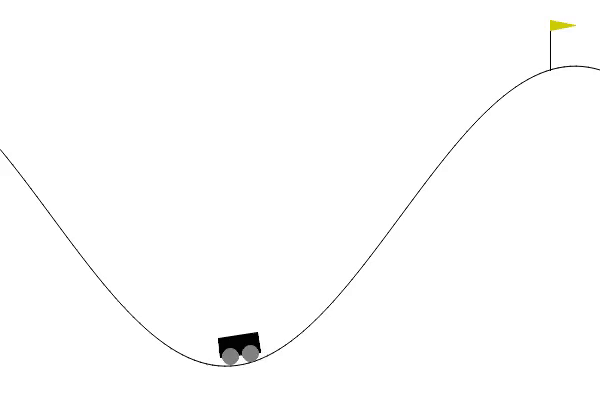